# 📝 Project Overview

## 💡 Objective
This notebook trains a machine learning model to predict whether a NYC Green Taxi trip was paid in **cash**, using features available **after the trip ends**. The goal is to support fraud detection by identifying trips that may have been **mislabeled or manipulated** for financial gain.

## 🎯 Use Case: Fraud Detection

Taxi drivers or operators may misreport the method of payment to manipulate earnings or avoid oversight. The most common fraud scenario involves **underreporting a card payment as cash**, which allows the driver to:

- Pocket the fare without reporting it
- Avoid credit card processing fees
- Underreport income for tax or commission purposes

### 🚨 Common Fraud Scenario

#### What Actually Happens (Rider's Experience)
- A rider takes a 10-minute, \$15.50 ride and pays using a credit card with a \$2.50 tip.
- The transaction is processed through the backseat terminal.
- The rider receives a receipt and leaves.

#### What the Driver Records
| Field            | Value       |
|------------------|-------------|
| `payment_type`   | 2 (Cash) ❌ |
| `tip_amount`     | 0.00 ❌     |
| `total_amount`   | 13.00 ❌    |

- The driver **logs the trip as cash** to avoid reporting the full transaction.
- The \$15.50 collected from the rider is **pocketed**, but only \$13.00 is reported.
- This creates a **mismatch** between what likely happened and what's recorded.

A machine learning model trained on normal trip patterns can flag this as suspicious if it predicts the trip was likely paid by **card**, but it’s logged as **cash**.

## 📦 Dataset

We use NYC Green Taxi Trip data from January to March 2021:
- `green_tripdata_2021-01.parquet` → **Train**
- `green_tripdata_2021-02.parquet` → **Validation**
- `green_tripdata_2021-03.parquet` → **Test**

Each record includes trip metadata such as:
- Pickup/drop-off location and time
- Fare amount, tolls, surcharges
- Trip duration and distance
- Payment type and vendor

Data dictionary -> https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf

## 🔒 Feature Selection Strategy

To prevent **target leakage**, we exclude features that directly depend on or reveal the actual payment method:

- ❌ `payment_type` — it is the target
- ❌ `tip_amount` — strongly correlated with card payments
- ❌ `is_tipped` — binary derived from `tip_amount`

Instead, we use **post-trip features** such as:
- Fare and distance
- Pickup/drop-off zones and timestamps
- Surcharges, taxes, and trip structure

These features allow the model to **infer whether a trip likely involved a cash or card payment**, enabling auditing systems to flag mismatches.


In [1]:
# 📦 Imports
import pandas as pd
import numpy as np
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 📁 File paths
train_path = "../data/green_tripdata_2021-01.parquet"
val_path = "../data/green_tripdata_2021-02.parquet"
test_path = "../data/green_tripdata_2021-03.parquet"

In [3]:
# 🧹 Load and preprocess
def load_and_prepare(path):
    df = pd.read_parquet(path)

    # Drop rows with essential missing values
    df = df.dropna(subset=[
        "payment_type", "fare_amount", "trip_distance",
        "lpep_pickup_datetime", "lpep_dropoff_datetime"
    ])

    # Target: is the trip marked as cash?
    df["is_cash_payment"] = (df["payment_type"] == 2).astype(int)

    # Feature engineering
    df["pickup_hour"] = pd.to_datetime(df["lpep_pickup_datetime"]).dt.hour
    df["pickup_weekday"] = pd.to_datetime(df["lpep_pickup_datetime"]).dt.weekday
    df["trip_duration_minutes"] = (
        pd.to_datetime(df["lpep_dropoff_datetime"]) - pd.to_datetime(df["lpep_pickup_datetime"])
    ).dt.total_seconds() / 60

    # Remove invalid trips
    df = df[
        (df["fare_amount"] > 0) &
        (df["trip_distance"] > 0) &
        (df["trip_duration_minutes"] > 0)
    ]

    # Final feature set (post-trip only, no leakage)
    features = [
        "fare_amount", "trip_distance", "passenger_count",
        "pickup_hour", "pickup_weekday", "trip_duration_minutes",
        "RatecodeID", "VendorID", "trip_type",
        "PULocationID", "DOLocationID",
        "congestion_surcharge", "extra", "tolls_amount",
        "mta_tax", "improvement_surcharge"
    ]

    X = df[features].copy()
    y = df["is_cash_payment"]

    # Fill & cast
    X["RatecodeID"] = X["RatecodeID"].fillna(1).astype(int)
    X["VendorID"] = X["VendorID"].fillna(1).astype(int)
    X["trip_type"] = X["trip_type"].fillna(1).astype(int)
    X["PULocationID"] = X["PULocationID"].fillna(0).astype(int)
    X["DOLocationID"] = X["DOLocationID"].fillna(0).astype(int)
    X["congestion_surcharge"] = X["congestion_surcharge"].fillna(0)
    X["extra"] = X["extra"].fillna(0)
    X["tolls_amount"] = X["tolls_amount"].fillna(0)
    X["mta_tax"] = X["mta_tax"].fillna(0)
    X["improvement_surcharge"] = X["improvement_surcharge"].fillna(0)

    return X, y

In [4]:
# 📊 Load datasets
X_train, y_train = load_and_prepare(train_path)
X_val, y_val = load_and_prepare(val_path)
X_test, y_test = load_and_prepare(test_path)

# 🔍 Quick look
print("Train shape:", X_train.shape)
display(X_train.head())


Train shape: (38316, 16)


,fare_amount,trip_distance,passenger_count,pickup_hour,pickup_weekday,trip_duration_minutes,RatecodeID,VendorID,trip_type,PULocationID,DOLocationID,congestion_surcharge,extra,tolls_amount,mta_tax,improvement_surcharge
0,5.5,1.01,1.0,0,4,3.933333,1,2,1,43,151,0.00,0.5,0.0,0.5,0.3
1,10.0,2.53,1.0,0,4,8.750000,1,2,1,166,239,2.75,0.5,0.0,0.5,0.3
2,6.0,1.12,1.0,0,4,5.966667,1,2,1,41,42,0.00,0.5,0.0,0.5,0.3
3,8.0,1.99,1.0,23,3,7.083333,1,2,1,168,75,0.00,0.5,0.0,0.5,0.3
7,3.5,0.45,6.0,0,4,2.316667,1,2,1,75,75,0.00,0.5,0.0,0.5,0.3


In [5]:
# Merge for EDA
train_df = X_train.copy()
train_df["is_cash_payment"] = y_train

In [52]:
# Count of cash (1) vs. non-cash (0)
counts = y_train.value_counts().sort_index()
percentages = y_train.value_counts(normalize=True).sort_index() * 100

# Display nicely
summary = pd.DataFrame({
    "Payment Type": ["Non-Cash (0)", "Cash (1)"],
    "Count": counts.values,
    "Percentage": percentages.values.round(2)
})

display(summary)


,Payment Type,Count,Percentage
0,Non-Cash (0),23186,60.51
1,Cash (1),15130,39.49


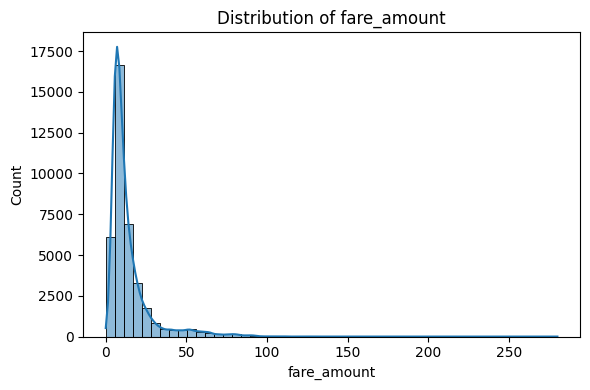

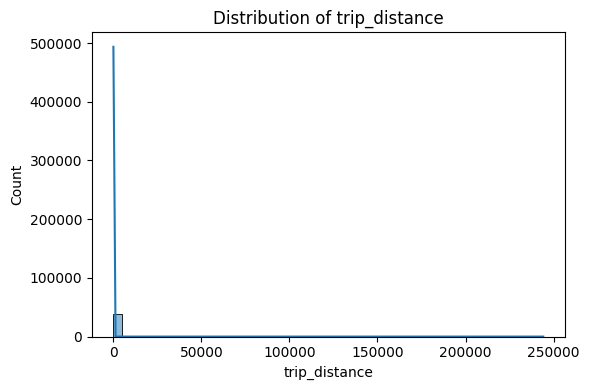

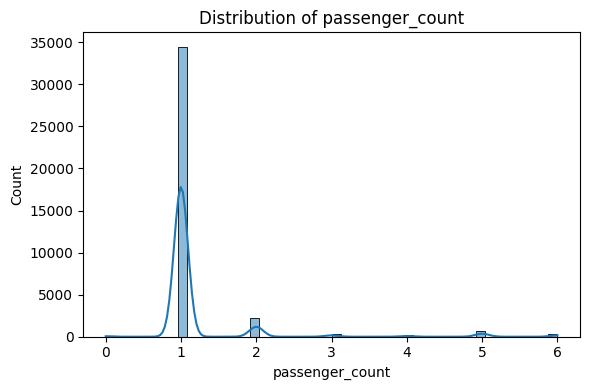

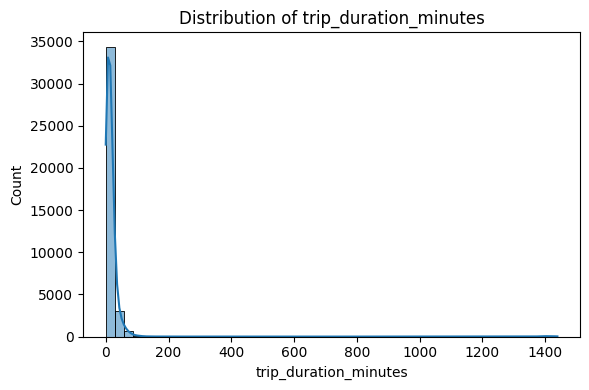

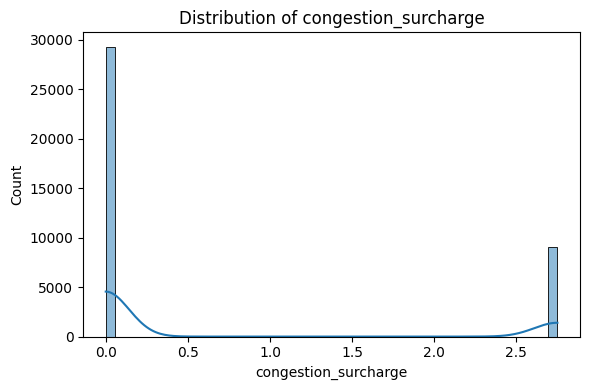

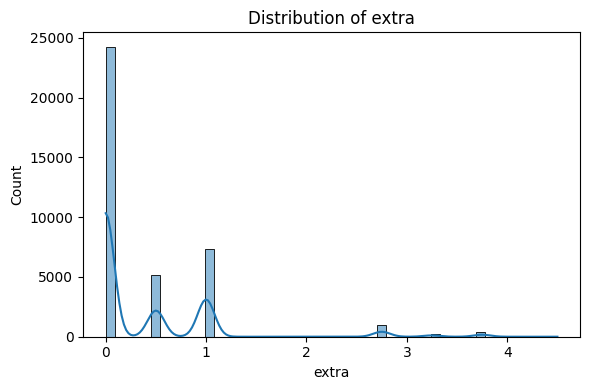

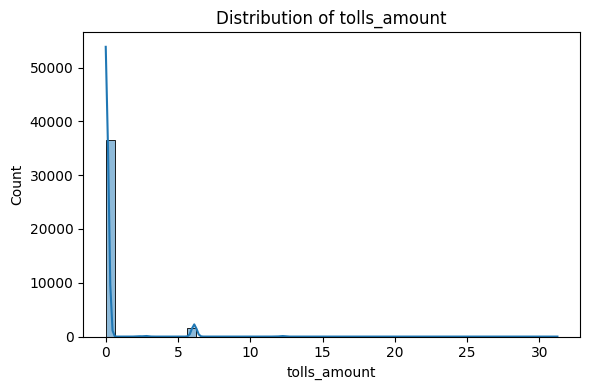

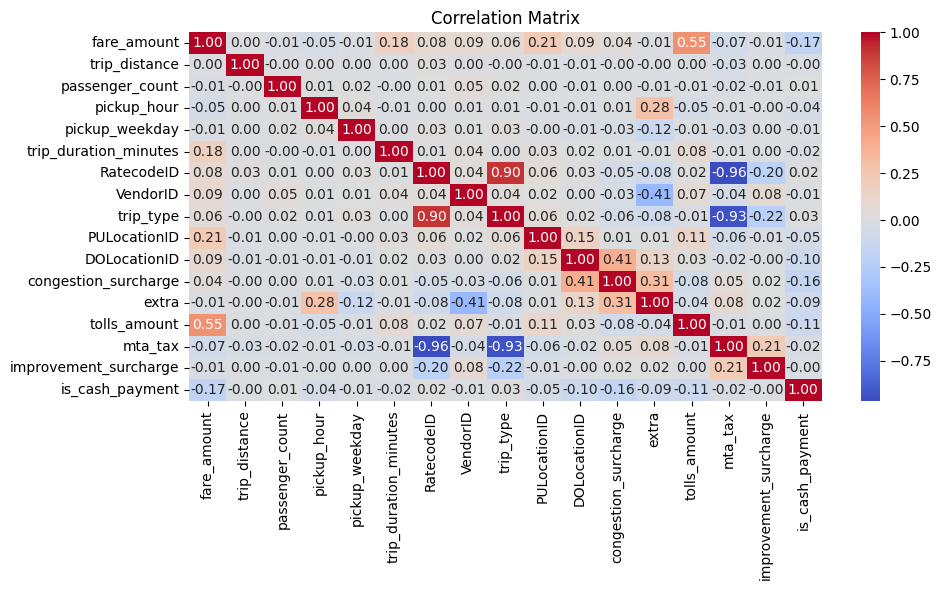

In [6]:
# Numeric distributions
numeric_cols = [
    "fare_amount", "trip_distance", "passenger_count",
    "trip_duration_minutes", "congestion_surcharge",
    "extra", "tolls_amount"
]
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(train_df[col], bins=50, kde=True)
    plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()

# Correlation
plt.figure(figsize=(10, 6))
corr = train_df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

## 📊 Feature Correlation Analysis

We examined the correlation matrix to understand the relationships between features and the target variable `is_cash_payment`. This helps us identify the most informative variables and assess potential multicollinearity in the dataset.

### 🔍 Correlation with Target: `is_cash_payment`

The goal is to predict whether a trip was paid in **cash** (vs. card), based on post-trip information.

| Feature                | Correlation | Interpretation |
|------------------------|-------------|----------------|
| `fare_amount`          | **-0.17**   | Higher fares are more likely to be paid with **card**. Cash trips tend to be shorter and cheaper. |
| `trip_type`            | **-0.16**   | Dispatch trips (`trip_type = 2`) are usually arranged through apps and paid by **card**. |
| `tolls_amount`         | **-0.10**   | Tolls are more common on longer trips, which are more frequently paid with **card**. |
| `RatecodeID`           | **-0.10**   | Special fare types (e.g. JFK Flat Fare) typically involve **card** transactions. |
| `extra`                | **-0.09**   | Additional fees (e.g. night surcharge, rush hour) slightly increase likelihood of **card** payment. |
| `pickup_hour`, `pickup_weekday` | ~0.00 | Time-based features show minimal direct correlation with payment type. |
| `trip_distance`, `trip_duration_minutes` | ~0.00 | Weak linear correlation, but may contribute through interactions with fare and surcharges. |
| `PULocationID`, `DOLocationID` | ~0.00 | Pickup/dropoff zones alone do not strongly predict payment type, though geographic patterns may emerge via interactions. |

---

## 🔁 Notable Feature Interactions (with Data Dictionary Context)

Several features exhibit strong pairwise correlations due to their **operational relationships**, as defined by the TLC.

- `trip_type` and `RatecodeID` are **highly correlated (0.90)**  
  - **`trip_type`**:
    - `1`: Street-hail (metered)
    - `2`: Dispatch (pre-arranged or app-based)
  - **`RatecodeID`** reflects fare pricing logic:
    - `1`: Standard metered rate
    - `2`: JFK Flat Fare
    - `3`: Newark
    - `5`: Nassau/Westchester
    - `6`: Negotiated fare

  ➤ *Dispatch trips often use flat or negotiated fares, which leads to consistent alignment between `trip_type` and `RatecodeID`.*

---

- `RatecodeID` and `mta_tax` also show strong dependency  
  - **`mta_tax`** is a flat $0.50 fee required on most NYC trips.
  - Trips with non-standard rate codes (e.g., out-of-city or negotiated fares) may be **exempt**, creating a correlation.

  ➤ *Trips that bypass standard metering logic may also avoid certain mandatory surcharges, reinforcing this relationship.*

---

- `tolls_amount` and `fare_amount` have moderate correlation (0.55)  
  - Longer or airport-bound trips often include tolls, which increase the total fare.
  - These are more likely to be paid by **card**, as they exceed what passengers commonly carry in cash.

---

- `trip_type` and `mta_tax`, `tolls_amount`, and `RatecodeID` show **compound relationships**  
  ➤ *For example, a dispatch trip (trip_type = 2) with RatecodeID = 2 (JFK Flat Fare) will often have tolls and be paid by card.*

---

## ✅ Modeling Takeaways

- **No single feature is dominant** in predicting payment type.
- Weak correlations to `is_cash_payment` indicate that **complex interactions** (e.g., short trip + no toll + low fare) are more informative than individual fields.
- The use of an **interpretable, interaction-aware model** like an Explainable Boosting Machine (EBM) is appropriate for this problem, as it can capture nuanced patterns in fare structure, time, location, and vendor behavior.



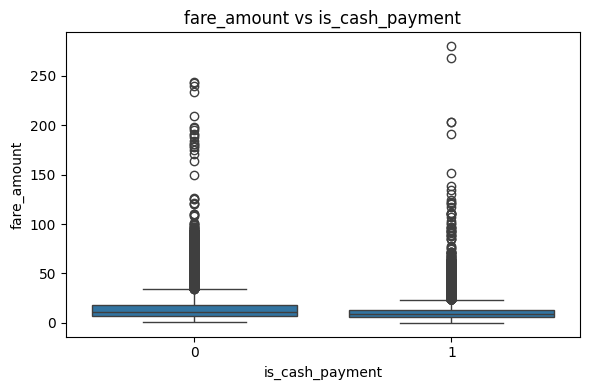

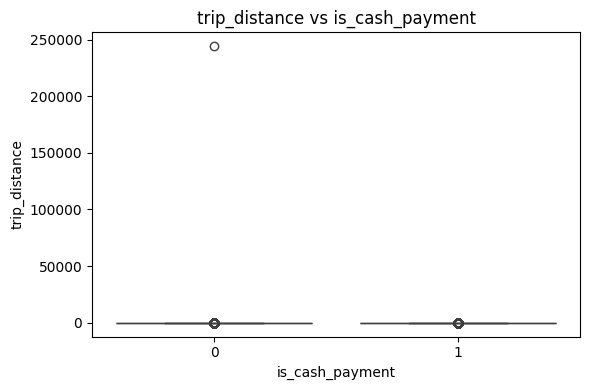

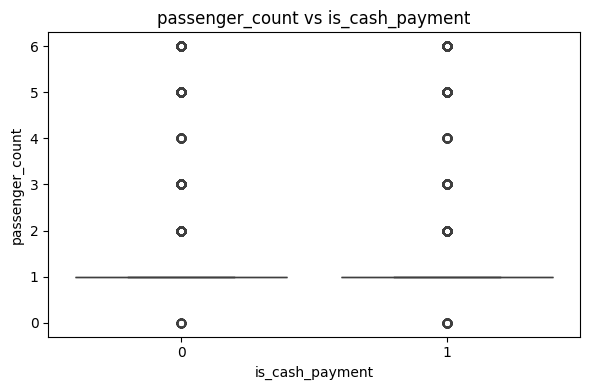

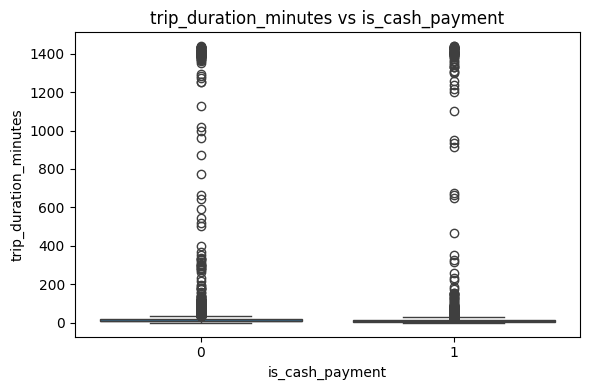

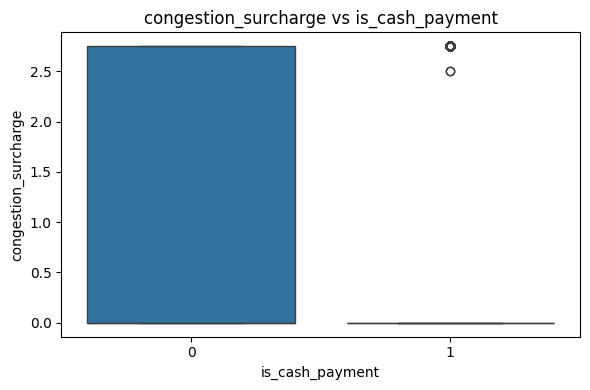

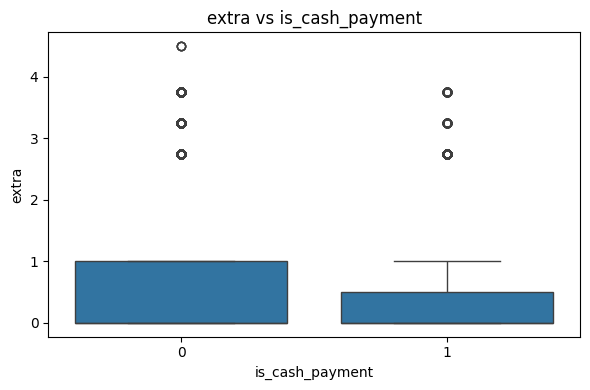

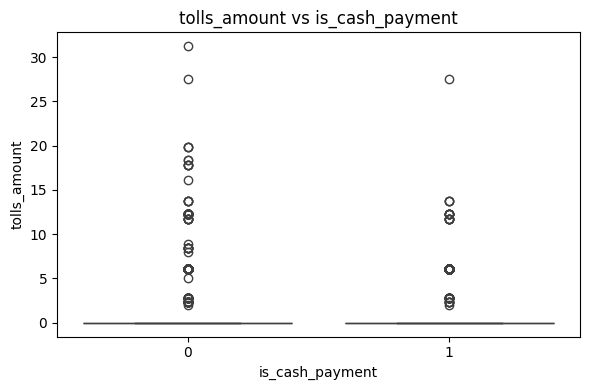

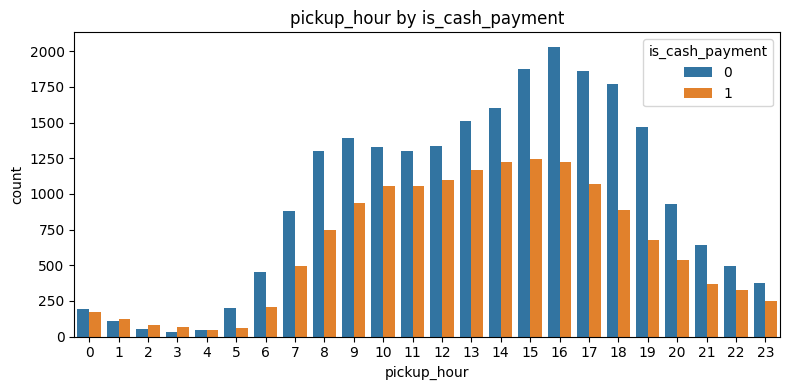

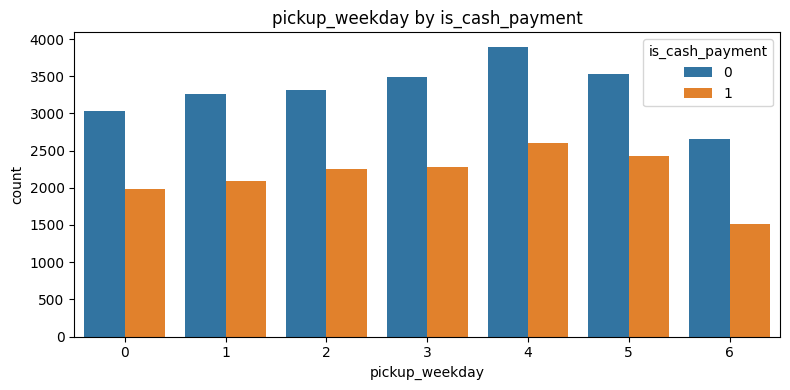

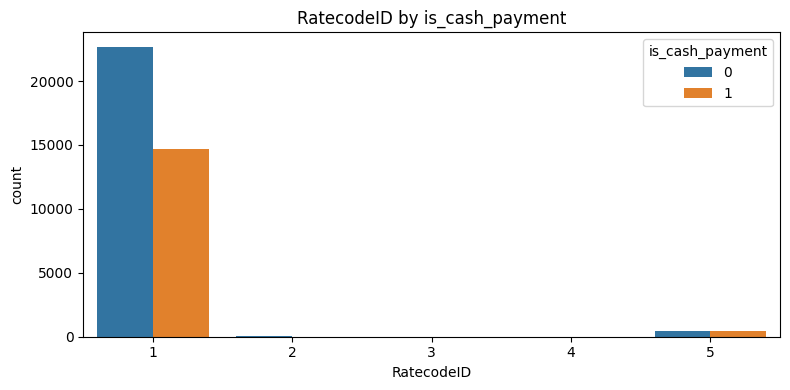

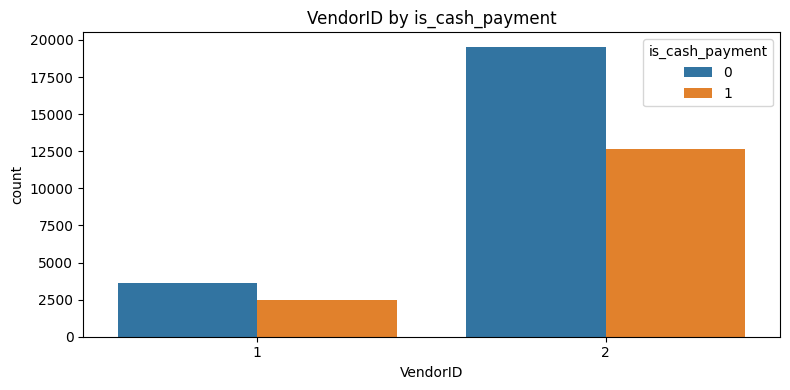

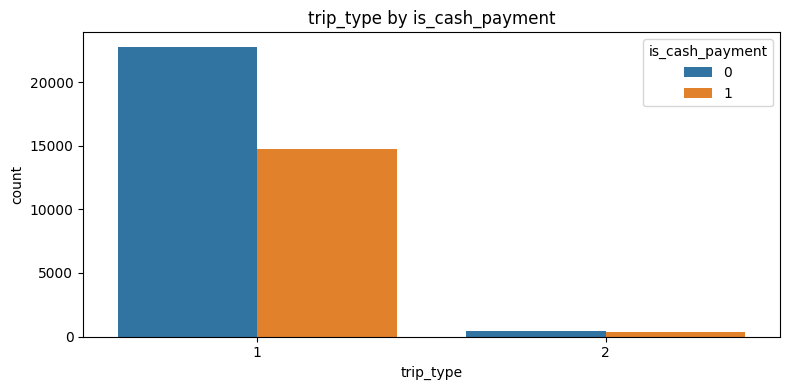

In [7]:
# Box plots vs. target
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=train_df, x="is_cash_payment", y=col)
    plt.title(f"{col} vs is_cash_payment")
    plt.tight_layout()
    plt.show()

# Categorical counts
categorical_cols = ["pickup_hour", "pickup_weekday", "RatecodeID", "VendorID", "trip_type"]
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=train_df, x=col, hue="is_cash_payment")
    plt.title(f"{col} by is_cash_payment")
    plt.tight_layout()
    plt.show()


📋 Classification Report: Validation
              precision    recall  f1-score   support

           0       0.70      0.82      0.76     20938
           1       0.60      0.43      0.50     12852

    accuracy                           0.67     33790
   macro avg       0.65      0.63      0.63     33790
weighted avg       0.66      0.67      0.66     33790



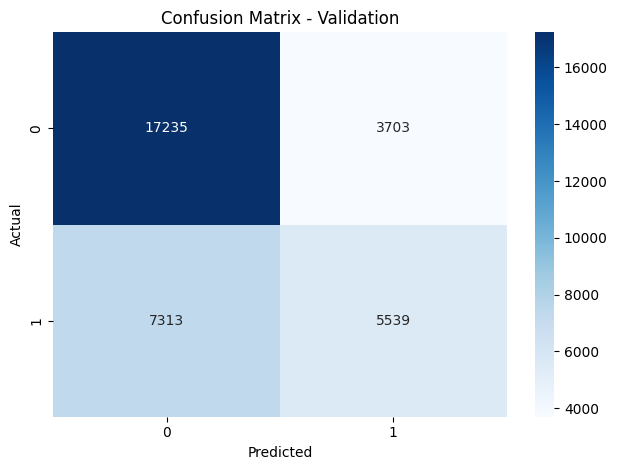


📋 Classification Report: Test
              precision    recall  f1-score   support

           0       0.68      0.83      0.75     24397
           1       0.63      0.43      0.51     16574

    accuracy                           0.67     40971
   macro avg       0.66      0.63      0.63     40971
weighted avg       0.66      0.67      0.65     40971



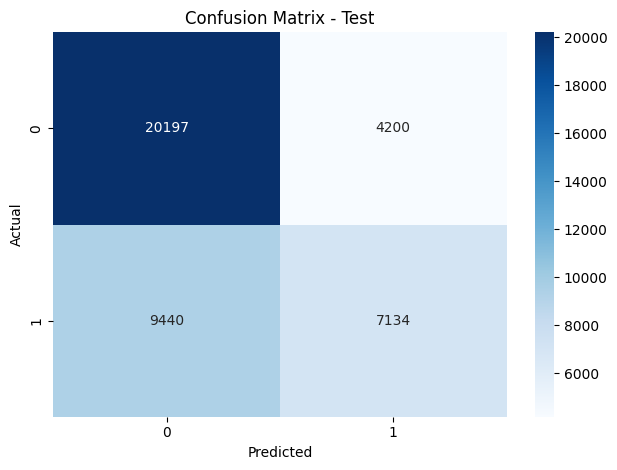

In [10]:
# ⚙️ Train EBM
ebm = ExplainableBoostingClassifier(random_state=42)
ebm.fit(X_train, y_train)

# 📈 Evaluation
def evaluate(model, X, y, dataset_name="Validation"):
    y_pred = model.predict(X)
    print(f"\n📋 Classification Report: {dataset_name}")
    print(classification_report(y, y_pred))

    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
    plt.title(f"Confusion Matrix - {dataset_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

evaluate(ebm, X_val, y_val, "Validation")
evaluate(ebm, X_test, y_test, "Test")

In [11]:
# 📊 Global Explainability
from interpret import show
ebm_global = ebm.explain_global()
ebm_global.visualize()


/home/nuno_paiva_nos_pt/envs/mlops_env/lib/python3.8/site-packages/sklearn/utils/_bunch.py:35: FutureWarning:

Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.



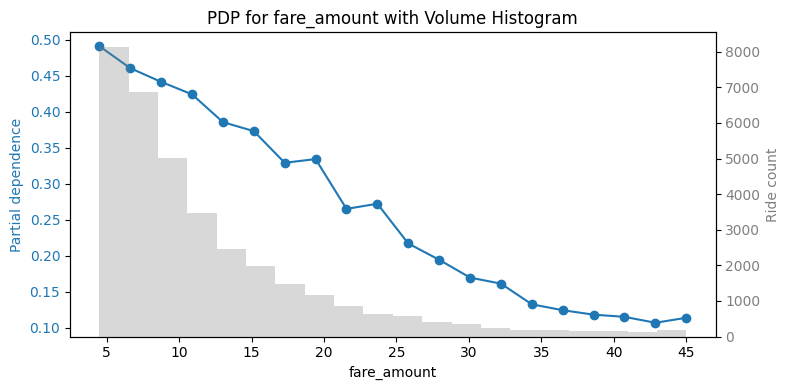

In [56]:
# Partial Dependence Plot (PDP) from Interpret-EBM library doesn't render in vs-code
# So we use sklearn's PDP

import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence

feature_name = "fare_amount"

# Get PDP values (no auto-plot)
pdp_result = partial_dependence(ebm, X=X_train, features=[feature_name], grid_resolution=20)
pdp_x = pdp_result["values"][0]
pdp_y = pdp_result["average"][0]

# Filter histogram to the PDP x range
fare_min, fare_max = min(pdp_x), max(pdp_x)
hist_data = X_train[(X_train[feature_name] >= fare_min) & (X_train[feature_name] <= fare_max)][feature_name]

# Plot
fig, ax1 = plt.subplots(figsize=(8, 4))

color = "tab:blue"
ax1.set_xlabel(feature_name)
ax1.set_ylabel("Partial dependence", color=color)
ax1.plot(pdp_x, pdp_y, color=color, marker='o')
ax1.tick_params(axis="y", labelcolor=color)

# Histogram (second y-axis)
ax2 = ax1.twinx()
color = "tab:gray"
ax2.set_ylabel("Ride count", color=color)
ax2.hist(hist_data, bins=20, alpha=0.3, color=color)
ax2.tick_params(axis="y", labelcolor=color)

plt.title("PDP for fare_amount with Volume Histogram")
plt.tight_layout()
plt.show()


## 💵 Partial Dependence: `fare_amount` with Volume Histogram

This plot shows how the **fare amount** (in dollars) influences the model’s prediction that a trip was paid in **cash** (`is_cash_payment = 1`), along with a histogram of how frequent each fare range appears in the training data.

### 🧠 Key Insights:

- The **likelihood of a cash payment decreases as fare increases**:
  - For **low fares** (~$5–10), the model predicts a **high probability** of cash payment (~45–50%).
  - For **high fares** ($30–45+), the predicted probability drops below **15%**.
- This suggests that **short, inexpensive rides** are more likely to be paid with **cash**, while longer or more expensive trips tend to be paid with **card**.
- The **distribution histogram** (gray bars) shows that the majority of trips are **clustered below $25**, meaning the model's strongest learning signal comes from this region.

### 🔎 Implication for Fraud Detection:

- A **high-fare trip** (e.g. $40+) marked as **cash** could be anomalous and worth further review, since it deviates from typical behavior learned by the model.
- The combination of low fare and cash is **expected** and should be considered normal unless other signals contradict it.



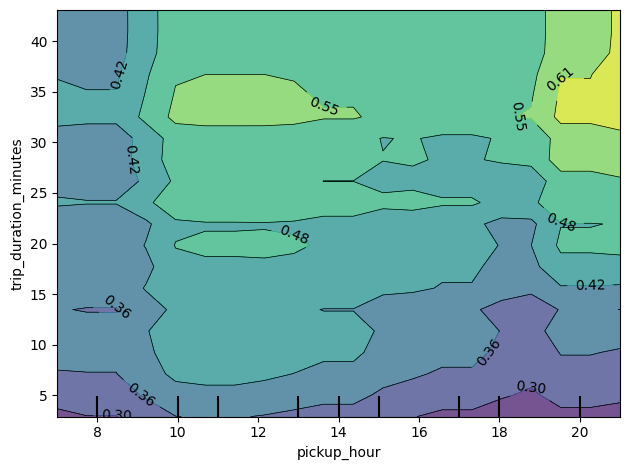

In [57]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Define the two features for the interaction term
features_to_plot = [("pickup_hour", "trip_duration_minutes")]

PartialDependenceDisplay.from_estimator(
    estimator=ebm,
    X=X_train,
    features=features_to_plot,
    kind="average",
    grid_resolution=20
)
plt.tight_layout()
plt.show()


## 🔍 Interaction Effect: `pickup_hour` × `trip_duration_minutes`

This plot shows the partial dependence of the `is_cash_payment` target on the **interaction** between:

- `pickup_hour` (hour of day the trip began)
- `trip_duration_minutes` (total duration of the trip)

### 🧠 Key Insights:

- **Short trips (<15 minutes)** during most pickup hours have a **low likelihood of being paid in cash** (probability ~0.30–0.40). These are often fast, businesslike trips likely paid by card.
- **Longer trips (30–45 minutes)** are **much more likely to be paid in cash**, with probabilities rising to **0.55–0.60+**.
- The **cash probability increases more sharply in the evening hours (after 18:00)** for longer trips. This may reflect commuter habits or reduced card usage later in the day.
- There is a **clear interaction**: neither pickup time nor duration alone explains cash payment behavior. The model detects that certain time+duration combinations significantly shift the probability.

### 🔎 Implication for Fraud Detection:

Trips that occur in **regions with low expected cash usage** (e.g., short midday trips) but are marked as cash could be flagged as suspicious. Conversely, the model helps avoid false positives for legitimate cash trips occurring in expected time-duration patterns.
